In [2]:
# Open API 호출
import requests

# 기상청 단기예보 API 
# "기상청41_단기예보 조회서비스_오픈API활용가이드_241128.zip" 내 워드 문서의 Call Back URL을 입력하세요. 
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtNcst"

# 요청 파라미터 
params = {
    "serviceKey": "BMLjeZg0dxPlyRlOpId+zqa6A8LvQHQWyfK4B+o1eeYqKb5qAYCnvNNyHGY+BWGYQCVT7Dm331Howg9sXeNYDw==",  # ← 일반 인증키(Decoding)로 바꾸세요
    "pageNo": "1",  # 페이지 번호
    "numOfRows": "10",  # 한 페이지 결과 수 
    "dataType": "JSON",    # 요청 자료 형식
    "base_date": "20250716",  # 발표 날짜(예: 오늘 날짜)
    "base_time": "1400",      # 발표 시간(정시 단위, 예: 0600(06시), 매시각 10분 이후 호출)

    "nx": "60",               # 예보 지점의 x좌표
    "ny": "127"               # 예보 지점의 y좌표
}
# API 호출 
response = requests.get(url, params=params)
# 응답 확인
print(response.status_code)

200


In [3]:
print(response.text[:500])

{"response":{"header":{"resultCode":"00","resultMsg":"NORMAL_SERVICE"},"body":{"dataType":"JSON","items":{"item":[{"baseDate":"20250716","baseTime":"1400","category":"PTY","nx":60,"ny":127,"obsrValue":"1"},{"baseDate":"20250716","baseTime":"1400","category":"REH","nx":60,"ny":127,"obsrValue":"88"},{"baseDate":"20250716","baseTime":"1400","category":"RN1","nx":60,"ny":127,"obsrValue":"0.8"},{"baseDate":"20250716","baseTime":"1400","category":"T1H","nx":60,"ny":127,"obsrValue":"23"},{"baseDate":"2


In [4]:
# JSON 파싱
data = response.json()
# 예보 데이터 항목 접근
items = data['response']['body']['items']['item']
# 상위 5개 항목만 출력
for item in items[:5]:
    print(item)

{'baseDate': '20250716', 'baseTime': '1400', 'category': 'PTY', 'nx': 60, 'ny': 127, 'obsrValue': '1'}
{'baseDate': '20250716', 'baseTime': '1400', 'category': 'REH', 'nx': 60, 'ny': 127, 'obsrValue': '88'}
{'baseDate': '20250716', 'baseTime': '1400', 'category': 'RN1', 'nx': 60, 'ny': 127, 'obsrValue': '0.8'}
{'baseDate': '20250716', 'baseTime': '1400', 'category': 'T1H', 'nx': 60, 'ny': 127, 'obsrValue': '23'}
{'baseDate': '20250716', 'baseTime': '1400', 'category': 'UUU', 'nx': 60, 'ny': 127, 'obsrValue': '-2.9'}


In [5]:
print(type(data))  # 중첩된 딕셔너리 구조 
print(type(items))

<class 'dict'>
<class 'list'>


In [6]:
import json
print(json.dumps(items[1], indent=4, ensure_ascii=False))

{
    "baseDate": "20250716",
    "baseTime": "1400",
    "category": "REH",
    "nx": 60,
    "ny": 127,
    "obsrValue": "88"
}


- obsrValue: RN1, T1H, UUU, VVV, WSD를 실수 또는 정수로 제공


In [7]:
print(f"불러온 데이터 수: {len(items)}개")

불러온 데이터 수: 8개


### 데이터 전처리

In [8]:
import pandas as pd
# 데이터프레임으로 변환
df = pd.DataFrame(items)
df.head()

# 데이터프레임으로 변환
df = pd.DataFrame(items)
df.head()

,baseDate,baseTime,category,nx,ny,obsrValue
0,20250716,1400,PTY,60,127,1
1,20250716,1400,REH,60,127,88
2,20250716,1400,RN1,60,127,0.8
3,20250716,1400,T1H,60,127,23
4,20250716,1400,UUU,60,127,-2.9


In [9]:
!pip install pandas
import pandas as pd

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   baseDate   8 non-null      object
 1   baseTime   8 non-null      object
 2   category   8 non-null      object
 3   nx         8 non-null      int64 
 4   ny         8 non-null      int64 
 5   obsrValue  8 non-null      object
dtypes: int64(2), object(4)
memory usage: 512.0+ bytes


In [11]:
# 크기 확인
df.shape

(8, 6)

In [12]:
# 날짜와 시간 컬럼을 합쳐 datetime 컬럼 만들기
df['datetime'] = pd.to_datetime(df['baseDate'] + df['baseTime'], format='%Y%m%d%H%M')

In [13]:
df.head()

,baseDate,baseTime,category,nx,ny,obsrValue,datetime
0,20250716,1400,PTY,60,127,1,2025-07-16 14:00:00
1,20250716,1400,REH,60,127,88,2025-07-16 14:00:00
2,20250716,1400,RN1,60,127,0.8,2025-07-16 14:00:00
3,20250716,1400,T1H,60,127,23,2025-07-16 14:00:00
4,20250716,1400,UUU,60,127,-2.9,2025-07-16 14:00:00


In [14]:
# categry 고유값 확인
unique_categories = df['category'].unique()
print(unique_categories)

['PTY' 'REH' 'RN1' 'T1H' 'UUU' 'VEC' 'VVV' 'WSD']


In [24]:
# category 해석
category_map = {
    "PTY": "강수형태",
    "REH": "습도(%)",
    "RN1": "1시간 강수량(mm)",
    "T1H": "기온(℃)",
    "UUU": "동서바람성분(m/s)",
    "VEC":"풍향(deg)", 
    "VVV":"남북바람성분(m/s)",
    "WSD": "풍속(m/s)"
}
# category 매핑
df['category_name'] = df['category'].map(category_map) # key값으로 Series를 매핑
df.head()


,baseDate,baseTime,category,nx,ny,obsrValue,datetime,category_name
0,20250716,1500,PTY,60,127,1,2025-07-16 15:00:00,강수형태
1,20250716,1500,REH,60,127,92,2025-07-16 15:00:00,습도(%)
2,20250716,1500,RN1,60,127,1.5,2025-07-16 15:00:00,1시간 강수량(mm)
3,20250716,1500,T1H,60,127,22.8,2025-07-16 15:00:00,기온(℃)
4,20250716,1500,UUU,60,127,-2.5,2025-07-16 15:00:00,동서바람성분(m/s)


In [17]:
# 불필요한 컬럼 제거 및 정렬
df = df[['datetime', 'category', 'category_name', 'obsrValue', 'nx', 'ny']]
df = df.sort_values(by='datetime').reset_index(drop=True)
df.head()


KeyError: "['category_name'] not in index"

In [16]:
# 숫자로 변환
df['obsrValue'] = pd.to_numeric(df['obsrValue'], errors='coerce') # coerce: 숫자로 변환이 불가능한 값은 NaN으로 바꿈

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       8 non-null      datetime64[ns]
 1   category       8 non-null      object        
 2   category_name  8 non-null      object        
 3   obsrValue      8 non-null      float64       
 4   nx             8 non-null      int64         
 5   ny             8 non-null      int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 512.0+ bytes


In [28]:
# 결측값 개수 확인 
print(df.isnull().sum())

datetime         0
category         0
category_name    0
obsrValue        0
nx               0
ny               0
dtype: int64


In [29]:
# 중복값 확인
df.duplicated(subset=['datetime', 'category'])


0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
dtype: bool

In [30]:
# 통계 분포 확인
df.describe()

,datetime,obsrValue,nx,ny
count,8,8.000000,8.0,8.0
mean,2025-07-16 15:00:00,29.237500,60.0,127.0
min,2025-07-16 15:00:00,-2.500000,60.0,127.0
25%,2025-07-16 15:00:00,1.150000,60.0,127.0
50%,2025-07-16 15:00:00,2.200000,60.0,127.0
75%,2025-07-16 15:00:00,40.100000,60.0,127.0
max,2025-07-16 15:00:00,115.000000,60.0,127.0
std,NaN,46.888224,0.0,0.0


In [31]:
!pip install -q seaborn

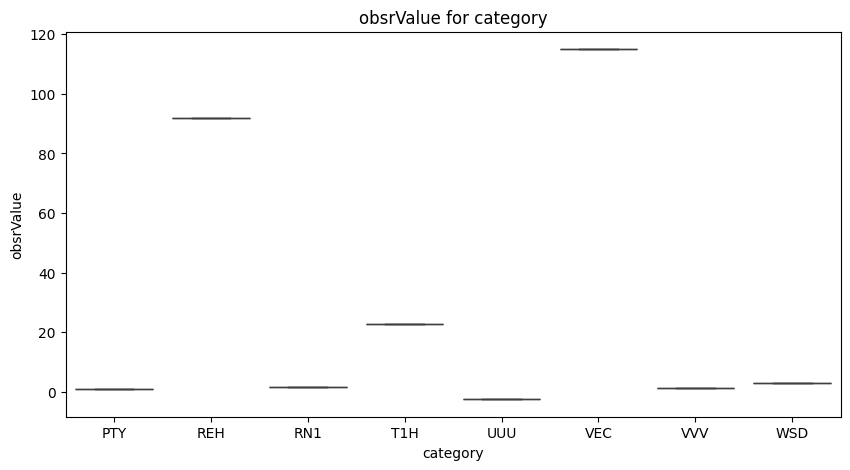

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# 카테고리별 boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='obsrValue', data=df)
plt.title("obsrValue for category")
plt.show()

VEC(풍향)은 보통 0-360 사이의 정수이므로 이상치가 아님
- 0도 = 북쪽
- 90도 = 동쪽
- 180도 = 남쪽
- 270도 = 서쪽

### DB에 저장 
SQLite에 저장 

In [33]:
import sqlite3

# DB 연결(없으면 새로 생성)
conn = sqlite3.connect("weather_data.db")

# 테이블 이름 예시: observed_weather
df.to_sql("observed_weather", conn, if_exists="append", index=False) # append: 기존 테이블에 이어 저장

# 연결 종료
conn.commit()
conn.close()

print("SQLite DB 저장 완료")


SQLite DB 저장 완료


In [36]:
# 데이터 타입 지정
from sqlalchemy import create_engine, String, Float, Integer, DateTime

# SQLAlchemy 엔진 생성 (to_sql의 dtype 인자 활용)
engine = create_engine('sqlite:///weather_data.db', echo=False) # echo=False: 실행되는 SQL 쿼리를 콘솔에 출력 X

# dtype 매핑
dtype_map = {
    "datetime": DateTime(),
    "category": String(10),  # 코드
    "category_name": String(50),  # 한글 
    "obsrValue": Float(),
    "nx": Integer(),     
    "ny": Integer()
}

# 저장(dtype 지정): weather_data DB 내 테이블로 저장 
df.to_sql("observed_weather", con=engine, if_exists="append", index=False, dtype=dtype_map)
# con: DB와 연결을 의미하는 객체, Pandas가 DB와 소통할 수 있게 연결
print("dtype 지정 후 SQLite에 observed_weather 테이블 저장 완료")


dtype 지정 후 SQLite에 observed_weather 테이블 저장 완료


In [35]:
!pip install SQLAlchemy


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 39.3 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   -------------------- ------------------- 1/2 [SQLAlchemy]
   ---------------------------------------- 2/2 [SQLAlchemy]



In [38]:
# 조회
query = "SELECT * FROM observed_weather WHERE category = 'T1H'"
result_df = pd.read_sql(query, con=engine)
result_df 

,datetime,category,category_name,obsrValue,nx,ny
0,2025-07-16 15:00:00,T1H,기온(℃),22.8,60,127
1,2025-07-16 15:00:00.000000,T1H,기온(℃),22.8,60,127
